#Web Scraping: Citylab.com

##Outline:
1. Web Scraping
2. Data Analysis
3. Keywords Examination

##1. Web Scraping

####1) First, take a look at the URL and HTML code 

9 Columns: 'commute','work','housing','weather','crime','polities','design, 'tech', 'navigator'

Under each column: table of contents （18-20 blogs per page)

####URL: "www.citylab.com/commute/?page=15"



![HTML code](https://dl.dropbox.com/s/jcgcq25nu17ca1r/Screen%20Shot%202015-06-25%20at%2010.20.06%20PM.png)


Each blog: Title, Description, Author.....


Disruption: Newsletters, Ads.....




![HTML code](https://dl.dropbox.com/s/8rihqxhubomey6b/Screen%20Shot%202015-06-25%20at%2010.20.34%20PM.png)

...and Blog post date, URL(hidden in the comments tag), and blog's category(indicated in the URL)
Disruption: Some comment tags were missing

![HTML Code](https://dl.dropbox.com/s/eoqs7gnwjmxni07/Screen%20Shot%202015-06-25%20at%2010.21.09%20PM.png)

###Variables: 
    1. Title
    2. Description
    3. Datetime
    4. Author
    5. Link
    6. Category

####2) Web scraping

In [ ]:
import re
import requests
import string
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup

In [ ]:
def sections_url(section, pagenumber):
        return 'http://www.citylab.com/' + section + '/?page=' + pagenumber

In [ ]:
### define the section
columns = ['commute','work','housing','weather','crime','politics','design','tech','navigator']

article_list = []
for section in columns:
    print "processing %s" %section
    
    ### no blog after page 200 (by June 24, 2015)
    for pagenumber in range(1,200):
        content_temp = requests.get(sections_url(section, str(pagenumber)))
        
        ### if the page does not exist: 
        if content_temp.status_code == 404:
            break
        if content_temp.status_code == 200:
            print "processing page %d" % pagenumber
            contents = BeautifulSoup(content_temp.text)
            
            ## find all 'div class' tags that include 'article':
            articleTags = contents.find_all(class_ = re.compile("article"))
            
            # for each article:
            for tag in articleTags:
                article = []
                title_article = tag.find('h2', {'class': "hed"}).get_text()
                descript_article = tag.find('p',{'class': "dek"}).get_text()
                datetime_article = tag.time.get('datetime')
                author_article = tag.find('li',{'class': "byline"}).get_text()
                
                # article's link and category are hidden in the comment tags
                commentTags = tag.find('li', {'class': "comments"})
                try:
                    link_1 = commentTags.a.get('href')                
                    link_2 = re.sub('#disqus_thread','',link_1)
                    link_article = 'http://www.citylab.com' + link_2
                    category_article = link_2.split('/')[1]
                
                # but some of the comment tags are missing:
                except AttributeError:
                    link_article = "NA"
                    category_article = "NA"
                
                
                article.append(title_article)
                article.append(descript_article)
                article.append(datetime_article)
                article.append(author_article)
                article.append(link_article)
                article.append(category_article)
                article.append(section)
                
                article_list.append(article)

article_dataframe = pd.DataFrame(article_list, columns=['title', 'description', 'datetime', 'author', 'link', 'category','section'])
article_dataframe.to_csv("/Users/yichun/webscraping/citylab.csv", encoding = 'utf-8')

##2. Data Analysis

In [5]:
import matplotlib.pyplot as plt
import pandas as pd 
import string
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
%matplotlib inline

In [10]:
citylab = '/Users/yichun/webscraping/citylab.csv'
a = pd.read_csv(citylab)

## remove the index column
a = a.iloc[:,1:]
print len(a)

# remove the duplicated article based on links
df1 = a.drop_duplicates('link')
df1 = df1.reset_index()
df1 = df1.iloc[:,1:]
print len(df1)

12820
11785


In [8]:
a.head()

,title,description,datetime,author,link,category,section
0,"The 'Great Migration' Was About Racial Terror,...",“The North and the Congress basically gave up ...,2015-06-24,Brentin Mock,http://www.citylab.com/crime/2015/06/the-great...,crime,commute
1,Yet More Evidence for the Social Cost of Drivi...,A study of Greater London linked loud traffic ...,2015-06-24,Eric Jaffe,http://www.citylab.com/commute/2015/06/yet-mor...,commute,commute
2,How Millennials Are Reviving Cleveland,The downtown population is at an all-time high...,2015-06-23,Eric Jaffe,http://www.citylab.com/work/2015/06/how-millen...,work,commute
3,How Can We Understand the Charleston Shootings...,A group of professors have created the #Charle...,2015-06-23,Brentin Mock,http://www.citylab.com/crime/2015/06/how-can-w...,crime,commute
4,Paris Is Making 7 Iconic Squares More Pedestri...,"“A city where you’re surrounded by hubbub, aba...",2015-06-23,Feargus O'Sullivan,http://www.citylab.com/commute/2015/06/paris-i...,commute,commute


####Extract year and month from the 'datetime' column

In [11]:
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['year'],df1['month'] = df1['datetime'].dt.year, df1['datetime'].dt.month
df1.head()

,title,description,datetime,author,link,category,section,year,month
0,"The 'Great Migration' Was About Racial Terror,...",“The North and the Congress basically gave up ...,2015-06-24,Brentin Mock,http://www.citylab.com/crime/2015/06/the-great...,crime,commute,2015,6
1,Yet More Evidence for the Social Cost of Drivi...,A study of Greater London linked loud traffic ...,2015-06-24,Eric Jaffe,http://www.citylab.com/commute/2015/06/yet-mor...,commute,commute,2015,6
2,How Millennials Are Reviving Cleveland,The downtown population is at an all-time high...,2015-06-23,Eric Jaffe,http://www.citylab.com/work/2015/06/how-millen...,work,commute,2015,6
3,How Can We Understand the Charleston Shootings...,A group of professors have created the #Charle...,2015-06-23,Brentin Mock,http://www.citylab.com/crime/2015/06/how-can-w...,crime,commute,2015,6
4,Paris Is Making 7 Iconic Squares More Pedestri...,"“A city where you’re surrounded by hubbub, aba...",2015-06-23,Feargus O'Sullivan,http://www.citylab.com/commute/2015/06/paris-i...,commute,commute,2015,6


####Number of Articles by Categories

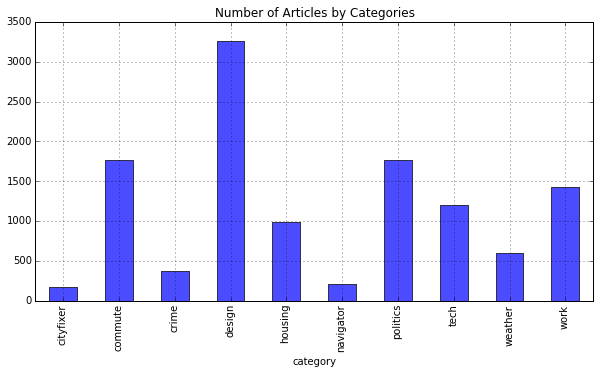

In [13]:
category = df1.groupby('category').count()
plt.figure(figsize=(10,5))
category.title.plot(kind='bar', title = 'Number of Articles by Categories', alpha = 0.7)

####Top 25 Authors

905


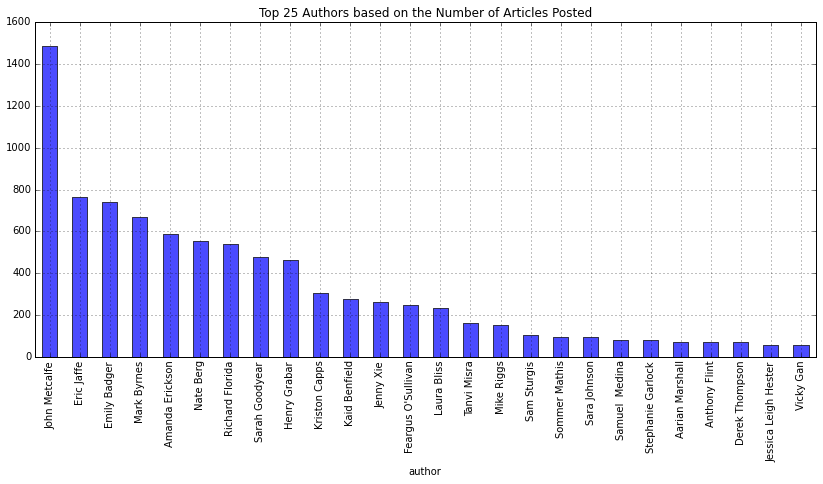

In [14]:
author = df1.groupby('author').count().sort(columns= 'title', ascending= False)
print len(author)
plt.figure(figsize=(14,6))
author_top25 = author.iloc[0:26,:]
author_top25.title.plot(kind='bar', title = 'Top 25 Authors based on the Number of Articles Posted', alpha = 0.7)

#### Articles Posted Over Years

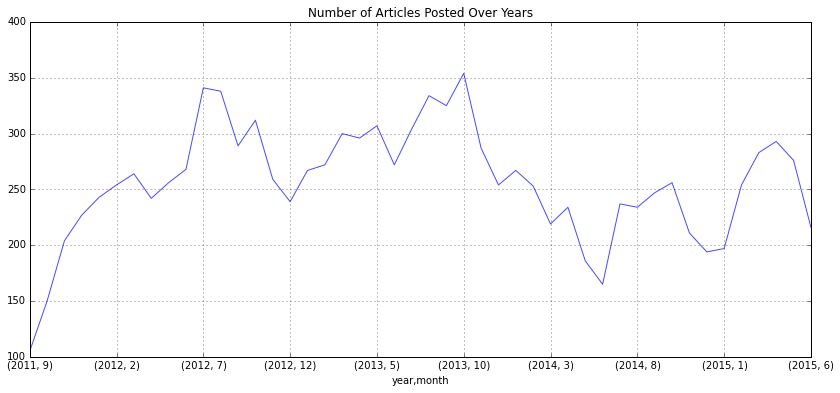

In [15]:
datetime = df1.groupby(['year','month']).count()
datetime.title.plot(figsize=(14, 6), color = 'blue', title = 'Number of Articles Posted Over Years', alpha = 0.7)

##3. Keywords Examination


###Question: Whether has Data Science become a popular topic in the urban planning community?


1. Define a set of keywords related to data science (e.g. "data science", "data mining", "visualization", "mapping"....)
2. Examine whether these keywords appeared in the article's title or description (Caveat: these keywords were not explicitly addressed in article's title or description)

In [18]:
def countWord(raw_string, result=None):
    if result is None:
        result = {i:0 for i in keywords}
    raw_string = raw_string.lower()
    for i in string.punctuation:
        raw_string = raw_string.replace(i, '')
    
    # Some keywords consist of only one word ("visualization"):
    raw_string_token = nltk.word_tokenize(raw_string)
    
    # While some keywords consist of two words ("data scientist"):
    raw_string_bigrams = list(ngrams(raw_string_token,2)) 
    
    for i in raw_string_bigrams:
        if i in keywords:
            result[i] += 1
    for k in raw_string_token:
        if k in keywords:
            result[k] += 1
    return result

#### Set a list of keywords related to Data Science

In [19]:
keywords = set([('data', 'science'),('data', 'mining'),('big', 'data'),('open', 'data'),('analytics'),('data', 'scientists'), ('data', 'scientist'), 'visualization','visual','data','science', 'map', 'maps', 'mapping',('machine', 'learning')])

####Examine whether keywords appeared in the article's title and description columns

In [21]:
b = df1
l = []
for x in range(len(b)):
    keywords = set([('data', 'science'),('data', 'mining'),('big', 'data'),('open', 'data'),('analytics'),('data', 'scientists'), ('data', 'scientist'), 'visualization','visual','data','science', 'map', 'maps', 'mapping',('machine', 'learning')])
    title = b['title'].iloc[x]
    title = str(title)
    descript = b['description'].iloc[x]
    descript = str(descript)
    result = countWord(title)
    total_count = countWord(descript,result = result)
    l.append(total_count)

####Create a list for each keyword

In [22]:
analytics = [i['analytics'] for i in l]
visual = [i['visual'] for i in l]
visualization = [i['visualization'] for i in l]
big_data = [i[('big','data')] for i in l]
data_mining = [i[('data', 'mining')] for i in l]
data_science = [i[('data', 'science')] for i in l]
data_scientist = [i[('data', 'scientist')] for i in l]
data_scientists = [i[('data', 'scientists')] for i in l]
machine_learning = [i[('machine', 'learning')] for i in l]
open_data = [i[('open', 'data')] for i in l]
data = [i['data'] for i in l]
science = [i['science']for i in l]
map_1 = [i['map']for i in l]
maps = [i['maps']for i in l]
mapping = [i['mapping']for i in l]

####Add keyword columns to the dataframe

In [23]:
df2 = df1
df2['analytics'] = pd.Series(analytics, index=df2.index)
df2['visual'] = pd.Series(visual, index=df2.index)
df2['visualization'] = pd.Series(visualization, index=df2.index)
df2['big_data'] = pd.Series(big_data, index=df2.index)
df2['data_mining'] = pd.Series(data_mining, index=df2.index)
df2['data_science'] = pd.Series(data_science, index=df2.index)
df2['data_scientist'] = pd.Series(data_scientist, index=df2.index)
df2['data_scientists'] = pd.Series(data_scientists, index=df2.index)
df2['machine_learning'] = pd.Series(machine_learning, index=df2.index)
df2['open_data'] = pd.Series(open_data, index = df2.index)
df2['data'] = pd.Series(data, index = df2.index)
df2['science'] = pd.Series(science, index = df2.index)
df2['map'] = pd.Series(map_1, index = df2.index)
df2['maps'] = pd.Series(maps, index = df2.index)
df2['mapping'] = pd.Series(mapping, index = df2.index)

In [24]:
## Get the sum of keywords for each article
keyword_s = [sum(df2.iloc[i,9:]) for i in range(len(df2))]

## Set a dummy variable, 1 = has at least one keyword, 0 = zero keyword
keyword_dummy = []
for i in range(len(df2)):
    if keyword_s[i] != 0:
        keyword_dummy.append(1)
    if keyword_s[i] == 0:
        keyword_dummy.append(0)  

In [25]:
df2['keyword_s'] = pd.Series(keyword_s, index = df2.index)
df2['keyword_dummy'] = pd.Series(keyword_dummy, index = df2.index)

In [26]:
df2.head()

,title,description,datetime,author,link,category,section,year,month,analytics,...,data_scientists,machine_learning,open_data,data,science,map,maps,mapping,keyword_s,keyword_dummy
0,"The 'Great Migration' Was About Racial Terror,...",“The North and the Congress basically gave up ...,2015-06-24,Brentin Mock,http://www.citylab.com/crime/2015/06/the-great...,crime,commute,2015,6,0,...,0,0,0,0,0,0,0,0,0,0
1,Yet More Evidence for the Social Cost of Drivi...,A study of Greater London linked loud traffic ...,2015-06-24,Eric Jaffe,http://www.citylab.com/commute/2015/06/yet-mor...,commute,commute,2015,6,0,...,0,0,0,0,0,0,0,0,0,0
2,How Millennials Are Reviving Cleveland,The downtown population is at an all-time high...,2015-06-23,Eric Jaffe,http://www.citylab.com/work/2015/06/how-millen...,work,commute,2015,6,0,...,0,0,0,0,0,0,0,0,0,0
3,How Can We Understand the Charleston Shootings...,A group of professors have created the #Charle...,2015-06-23,Brentin Mock,http://www.citylab.com/crime/2015/06/how-can-w...,crime,commute,2015,6,0,...,0,0,0,0,0,0,0,0,0,0
4,Paris Is Making 7 Iconic Squares More Pedestri...,"“A city where you’re surrounded by hubbub, aba...",2015-06-23,Feargus O'Sullivan,http://www.citylab.com/commute/2015/06/paris-i...,commute,commute,2015,6,0,...,0,0,0,0,0,0,0,0,0,0


#### The number of articles has at least one keyword in the title and description:

#### 805 out of 11785: 6.83%

In [28]:
keywords_dummy_count = [i for i in keyword_dummy if i!=0]
len(keywords_dummy_count)

805

In [29]:
keyword_time = df2.groupby(['year','month']).sum()

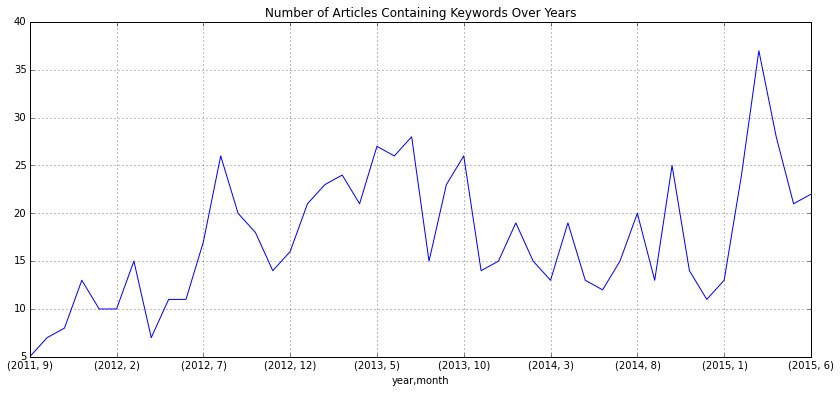

In [31]:
keyword_time.keyword_dummy.plot(figsize=(14, 6), color = 'blue', title = 'Number of Articles Containing Keywords Over Years')